D:\anaconda\envs\ds_practicum_env\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


p-значение:  4.691093972212593e-165
Отвергаем нулевую гипотезу
p-значение:  0.5151265845525059
Не получилось отвергнуть нулевую гипотезу


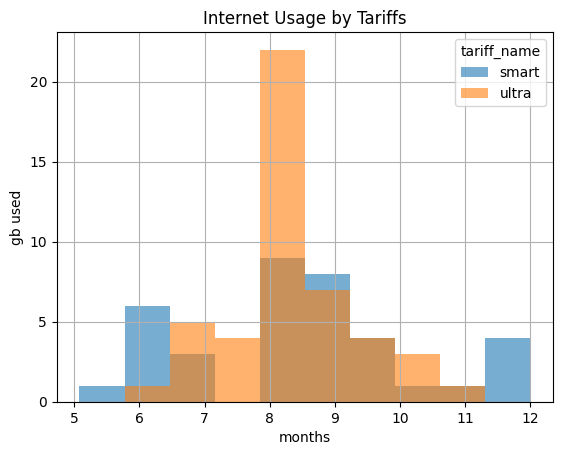

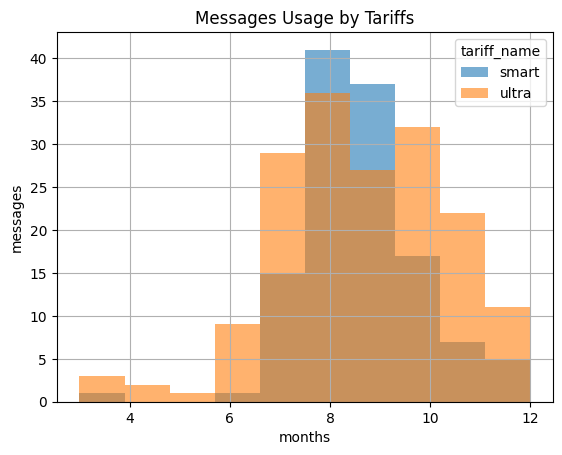

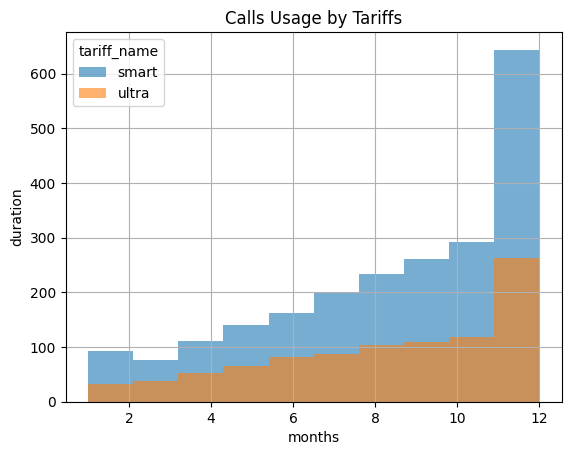

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_calls = pd.read_csv(r'D:\calls.csv')
df_internet = pd.read_csv(r'D:\internet.csv')
df_messages = pd.read_csv(r'D:\messages.csv')
df_tariffs = pd.read_csv(r'D:\tariffs.csv')
df_users = pd.read_csv(r'D:\users.csv')


df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format = '%Y-%m-%dT%H:%M:%S')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format = '%Y-%m-%dT%H:%M:%S')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format = '%Y-%m-%dT%H:%M:%S')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format = '%Y-%m-%dT%H:%M:%S')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y-%m-%dT%H:%M:%S')

df_calls['duration'] = df_calls['duration'].replace(0, 1)

df_users.set_axis(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff_name'], axis = 'columns', inplace = True)

df_messages['month_number'] = df_messages['message_date'].dt.month
df_internet['month_number'] = df_internet['session_date'].dt.month
df_calls['month_number'] = df_calls['call_date'].dt.month

table_user_tar = df_tariffs
for df in [df_users]:
    table_user_tar = table_user_tar.merge(df, on = ['tariff_name'], how = 'left')
    
user_call = table_user_tar
for df in [df_calls]:
    user_call = user_call.merge(df, on = ['user_id'], how = 'left')
    
user_call_sum = user_call.pivot_table(index = ['user_id', 'month_number'], values='duration', aggfunc=['count', 'sum'])
calls_per_month = df_calls.groupby(['user_id', 'call_date']).agg({'duration': ['count', 'sum']})
calls_per_month.columns = ['calls', 'minutes']

table_user_call = user_call_sum
for df in [user_call]:
    table_user_call = table_user_call.merge(df, on = ['user_id', 'month_number'], how = 'left')

df_calls = df_calls.rename(columns={'id': 'calls_id'})

pivot_call = table_user_call.pivot_table(index = ['user_id', 'age', 'city', 'month_number', 'tariff_name', 'rub_monthly_fee', 'minutes_included', 'messages_included', 'rub_per_message', 'rub_per_gb', 'rub_per_minute', 'mb_per_month_included'], values = ['duration'], aggfunc=['count', 'sum'])

user_messages = table_user_tar
for df in [df_messages]:
    user_messages = user_messages.merge(df, on = ['user_id'], how = 'left')
    
user_messages_sum = user_messages.pivot_table(index = ['user_id', 'month_number'], values='id', aggfunc=['count'])
merge = pivot_call.join(user_messages_sum)

mb_used = table_user_tar
for df in [df_internet]:
    mb_used = mb_used.merge(df, on = ['user_id'], how = 'left')

mb_used_sum = mb_used.pivot_table(index = ['user_id', 'month_number'], values='mb_used', aggfunc=['sum'])
full_table = merge.join(mb_used_sum)
full_table.columns = ['calls_count', 'sum_duration_of_calls', 'messages', 'mb_used']

full_table['messages'] = full_table['messages'].fillna(0)
full_table['mb_used'] = full_table['mb_used'].fillna(0)
full_table.reset_index(inplace=True)

full_table['gb_per_month_included'] = full_table['mb_per_month_included'] // 1024

def gb_used(x):
    return int(x // 1024) + 1

full_table['gb_used'] = full_table['mb_used'].apply(gb_used)        
          
full_table['calls_revenue'] = ((full_table['sum_duration_of_calls'] - full_table['minutes_included']) * full_table['rub_per_minute'])
full_table['messages_revenue'] = ((full_table['messages'] - full_table['messages_included']) * full_table['rub_per_message'])
full_table['gb_revenue'] = ((full_table['gb_used'] - full_table['gb_per_month_included']) * full_table['rub_per_gb'])

full_table['messages_revenue'] = full_table['messages_revenue'].clip(lower = 0)
full_table['calls_revenue'] = full_table['calls_revenue'].clip(lower = 0)
full_table['gb_revenue'] = full_table['gb_revenue'].clip(lower = 0)

full_table['calls_revenue'] = full_table['calls_revenue'].astype('int')
full_table['messages_revenue'] = full_table['messages_revenue'].astype('int')
full_table['gb_revenue'] = full_table['gb_revenue'].astype('int')

full_table['revenue'] = full_table['rub_monthly_fee'] + full_table['calls_revenue'] + full_table['messages_revenue'] + full_table['gb_revenue']
#display(full_table.info())
mean_internet_pivot = full_table.pivot_table(index='gb_used', columns='tariff_name', values='month_number', aggfunc='mean')
mean_messages_pivot = full_table.pivot_table(index='messages', columns='tariff_name', values='month_number', aggfunc='mean')
mean_duration_pivot = full_table.pivot_table(index='sum_duration_of_calls', columns='tariff_name', values='month_number', aggfunc='mean')

full_table_calcs = full_table.pivot_table(index = ['tariff_name'], values = ['sum_duration_of_calls', 'messages', 'gb_used'], aggfunc=['mean', 'var', 'std'])
#print(full_table_calcs)

mean_internet_pivot.plot(kind='hist', alpha=0.6, grid=True)
plt.title('Internet Usage by Tariffs')
plt.ylabel('gb used')
plt.xlabel('months')
#plt.show()

mean_messages_pivot.plot(kind='hist', alpha=0.6, grid=True)
plt.title('Messages Usage by Tariffs')
plt.ylabel('messages')
plt.xlabel('months')
#plt.show()

mean_duration_pivot.plot(kind='hist', alpha=0.6, grid=True)
plt.title('Calls Usage by Tariffs')
plt.ylabel('duration')
plt.xlabel('months')
#plt.show()

# H0: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны
from scipy import stats as st

smart_revenue = full_table[full_table['tariff_name'] == 'smart']['revenue']
ultra_revenue = full_table[full_table['tariff_name'] == 'ultra']['revenue']

results = st.ttest_ind(
smart_revenue,
ultra_revenue)
alpha = 0.05
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

#print(full_table.info())
#print(full_table[full_table['tariff_name'] == 'Москва']['revenue'])
# H0: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.
moscow_sample = full_table[full_table['city'] == 'Москва']['revenue']
regional_sample = full_table[full_table['tariff_name'] != 'Москва']['revenue']

results = st.ttest_ind(
moscow_sample,
regional_sample)
alpha = 0.05
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
